In [1]:
import os
import json 
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchmetrics import BLEUScore
from torchvision import transforms 
from transformers import ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader, random_split 
from torch.nn.functional import cross_entropy
from transformers import BertTokenizer, BertModel, ViTModel, BertConfig, AdamW, ViTConfig
from transformers import BertLMHeadModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


C:\Users\omrav\AppData\Roaming\Python\Python311\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
C:\Users\omrav\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any 

In [ ]:
class VQA_RAD_Dataset(Dataset):
    def __init__(self, json_dir, img_dir, transform=None):

        with open(json_dir, 'r') as file:
            self.data = json.load(file)

        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data[index]['image_name'])
        question = self.data[index]['question']
        answer = str(self.data[index]['answer'])

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, question, answer

In [3]:
image_dir = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\VQA_RAD\VQA_RAD Image Folder"
json_dir = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Dataset\VQA_RAD\VQA_RAD Dataset Public.json"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = VQA_RAD_Dataset(json_dir=json_dir, img_dir=image_dir, transform=transform)

In [4]:
def custom_collate_fn(batch):
    images, questions, answers = zip(*batch)
    images = torch.stack(images)  
    questions = list(questions)  
    answers = list(answers)      
    return images, questions, answers


train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")

Number of samples in train set: 1798
Number of samples in test set: 450


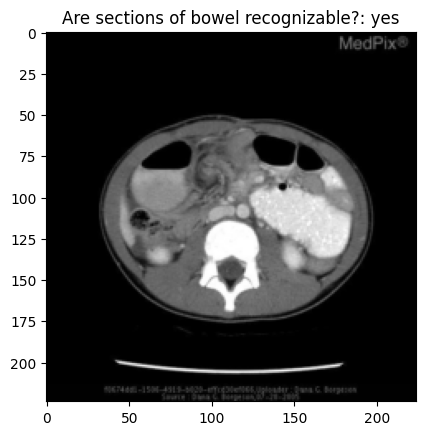

In [5]:
image, question, answer = train_dataset.__getitem__(-1)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{question}: {answer}")
plt.show()

In [6]:
class VQAModel(nn.Module):
    def __init__(self, bert, vit, answer_decoder_config):
        super(VQAModel, self).__init__()

        # Store preloaded BERT and ViT models
        self.bert = bert
        self.text_encoder = nn.ModuleList(self.bert.encoder.layer[:6])  # First 6 layers of BERT
        self.multimodal_encoder = nn.ModuleList(self.bert.encoder.layer[6:])  # Last 6 layers of BERT
        self.image_encoder = vit  # Preloaded Vision Transformer

        # Answer Decoder with cross-attention enabled, initialized from the config
        self.answer_decoder = BertLMHeadModel(answer_decoder_config)

    def forward(self, input_ids, attention_mask, images, decoder_input_ids, target_ids=None):
        # Step 1: Process Text Encoder (First 6 layers of BERT)
        text_embeddings = self._encode_text(input_ids, attention_mask)

        # Step 2: Process Image Encoder (ViT)
        image_embeddings = self.image_encoder(images).last_hidden_state

        # Step 3: Concatenate Text and Image Embeddings
        combined_embeddings = torch.cat((text_embeddings, image_embeddings), dim=1)

        # Step 4: Create Combined Attention Mask
        combined_attention_mask = torch.cat(
            [attention_mask, torch.ones((attention_mask.size(0), image_embeddings.size(1)), device=attention_mask.device)],
            dim=1
        )

        # Step 5: Process Multimodal Encoder (Last 6 layers of BERT)
        multimodal_embeddings = self._encode_multimodal(combined_embeddings, combined_attention_mask)

        # Step 6: Answer Decoder
        outputs = self.answer_decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=multimodal_embeddings,
            labels=target_ids  # Providing target IDs to calculate loss internally
        )

        logits = outputs.logits  # Predicted token logits
        loss = outputs.loss if target_ids is not None else None  # Loss if target_ids are provided

        return {"logits": logits, "loss": loss}

    def _encode_text(self, input_ids, attention_mask):
        # Initial text embeddings from input IDs using self.bert's embedding layer
        text_embeddings = self.bert.embeddings(input_ids=input_ids)
        
        # Expand attention mask to required shape for BERT encoder layers
        attention_mask_expanded = attention_mask.unsqueeze(1).unsqueeze(2).float()
        attention_mask_expanded = (1.0 - attention_mask_expanded) * -10000.0

        # Process through the first 6 layers of BERT for text encoding
        for layer in self.text_encoder:
            text_embeddings = layer(text_embeddings, attention_mask=attention_mask_expanded)[0]
        
        return text_embeddings

    def _encode_multimodal(self, combined_embeddings, combined_attention_mask):
        # Expand combined attention mask
        combined_attention_mask_expanded = combined_attention_mask.unsqueeze(1).unsqueeze(2).float()
        combined_attention_mask_expanded = (1.0 - combined_attention_mask_expanded) * -10000.0

        # Process through the last 6 layers of BERT for multimodal encoding
        for layer in self.multimodal_encoder:
            combined_embeddings = layer(combined_embeddings, attention_mask=combined_attention_mask_expanded)[0]

        return combined_embeddings

In [7]:
def train_vqa_model(model, dataloader, tokenizer, device='cuda', num_epochs=3, learning_rate=1e-5, model_checkpoint_path="vqa_model_checkpoint.pth"):
    """
    Train the VQA model with checkpointing and metric tracking.

    Parameters:
    - model: VQAModel instance
    - dataloader: DataLoader instance with training data
    - tokenizer: BertTokenizer instance
    - device: torch.device, either 'cuda' or 'cpu'
    - num_epochs: int, number of training epochs
    - learning_rate: float, learning rate for optimizer
    - model_checkpoint_path: str, path to save model checkpoint
    """
    
    # Define optimizer, loss function, and BLEU metric
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    bleu_metric = BLEUScore()
    
    # Load model and optimizer state from checkpoint if available
    start_epoch = 0
    if os.path.exists(model_checkpoint_path):
        checkpoint = torch.load(model_checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch + 1}")

    # Training loop
    model.to(device)
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0
        bleu_scores = []

        for images, questions, answers in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images = images.to(device)
            optimizer.zero_grad()

            # Tokenize questions and answers
            encoding = tokenizer(questions, padding='max_length', truncation=True, max_length=12, return_tensors='pt')
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            # decoder_input_ids = torch.tensor([[tokenizer.cls_token_id]] * input_ids.size(0), device=device)
            target_ids = tokenizer(answers, padding='max_length', truncation=True, max_length=12, return_tensors='pt')['input_ids'].to(device)
            decoder_input_ids = torch.full((input_ids.size(0), target_ids.size(1)), tokenizer.cls_token_id, device=device)

            # print(f"input_ids shape: {input_ids.shape}")
            # print(f"attention_mask shape: {attention_mask.shape}")
            # print(f"decoder_input_ids shape: {decoder_input_ids.shape}")
            # print(f"target_ids shape: {target_ids.shape}")

            # Forward pass
            outputs = model(input_ids, attention_mask, images, decoder_input_ids, target_ids)
            loss = outputs['loss']  # Access the loss from the standardized output
            logits = outputs['logits']  # Access logits to generate BLEU scores

            # Accumulate loss
            total_loss += loss.item()

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Calculate BLEU score
            generated_answers = tokenizer.batch_decode(logits.argmax(dim=-1), skip_special_tokens=True)
            bleu_scores.extend([bleu_metric(gen, [ref]).item() for gen, ref in zip(generated_answers, answers)])

        # Calculate metrics for the epoch
        avg_loss = total_loss / len(dataloader)
        avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Avg BLEU: {avg_bleu_score:.4f}")

        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'bleu_score': avg_bleu_score
        }, model_checkpoint_path)
        print(f"Model checkpoint saved at epoch {epoch + 1}")

    print("Training complete.")

In [8]:
def load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load pre-trained BERT and Vision Transformer models from state_dict checkpoints.
    
    Parameters:
    - bert_checkpoint_path (str): Path to the BERT model checkpoint (.pth file).
    - vit_checkpoint_path (str): Path to the Vision Transformer model checkpoint (.pth file).
    - device (str): Device to load models onto, 'cuda' or 'cpu'.
    
    Returns:
    - bert_model: Loaded BERT model with pre-trained weights.
    - vit_model: Loaded Vision Transformer model with pre-trained weights.
    """
    
    # Load BERT configuration and model
    bert_config = BertConfig.from_pretrained('bert-base-uncased')
    bert_model = BertModel(bert_config)
    bert_checkpoint = torch.load(bert_checkpoint_path, map_location=device)
    bert_model.load_state_dict(bert_checkpoint)
    bert_model.to(device)
    bert_model.eval()  # Set to evaluation mode if not training

    # Load Vision Transformer configuration and model
    vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = ViTModel(vit_config)
    vit_checkpoint = torch.load(vit_checkpoint_path, map_location=device)
    vit_model.load_state_dict(vit_checkpoint)
    vit_model.to(device)
    vit_model.eval()  # Set to evaluation mode if not training

    return bert_model, vit_model

bert_checkpoint_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\bert_model_checkpoint.pth"
vit_checkpoint_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\image_encoder_checkpoint.pth"

bert, vit = load_pretrained_models(bert_checkpoint_path, vit_checkpoint_path, device=device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# bert = BertModel.from_pretrained('bert-base-uncased')
# vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# Configure the answer decoder with cross-attention enabled
answer_decoder_config = BertConfig.from_pretrained('bert-base-uncased')
answer_decoder_config.is_decoder = True
answer_decoder_config.add_cross_attention = True

# Initialize the VQA model with preloaded models
model = VQAModel(bert, vit, answer_decoder_config).to(device)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Code Notebooks\vqa_model_checkpoint.pth"
# Start training
epochs = 20  # or any number of epochs you want to train for
metric_history = train_vqa_model(model=model, 
                                 dataloader=train_dataloader, 
                                 tokenizer=tokenizer, 
                                 device='cuda' if torch.cuda.is_available() else 'cpu', 
                                 num_epochs=epochs, 
                                 learning_rate=1e-5, 
                                 model_checkpoint_path=model_path)

d:\Anaconda\envs\CUDA1\Lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(


Resuming training from epoch 11


Epoch 11/20:   1%|          | 4/450 [00:48<1:30:32, 12.18s/it]


KeyboardInterrupt: 

In [10]:
model = VQAModel(bert, vit, answer_decoder_config).to(device)  # Initialize with your pre-trained components
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) 

model_path = r"C:\Users\omrav\OneDrive\Desktop\IITC AI\Fall 24\CS 512 Computer Vision\Project\Code Notebooks\vqa_model_checkpoint.pth"

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
print(f"Model and optimizer states loaded. Resuming from epoch {start_epoch}.")

Model and optimizer states loaded. Resuming from epoch 10.


In [47]:
def display_vqa_results(model, batch, tokenizer, max_answer_length=20, device='cuda'):
    """
    Display the VQA model results, including the image, question, generated answer, and ground truth answer.

    Parameters:
        model (VQAModel): The VQA model.
        batch (tuple): A batch of data from the dataloader containing images, questions, and answers.
        tokenizer (BertTokenizer): Tokenizer for encoding questions.
        max_answer_length (int): Maximum length for generated answers.
        device (str): Device to run the model on ('cuda' or 'cpu').
    """
    model.to(device)
    model.eval()
    
    # Unpack batch
    images, questions, ground_truth_answers = batch
    images = images.to(device)

    # Tokenize questions
    encoding = tokenizer(
        questions,
        padding='max_length',
        truncation=True,
        max_length=12,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Initialize the decoder input with the CLS token
    decoder_input_ids = torch.full((input_ids.size(0), 1), tokenizer.cls_token_id, device=device)

    # Forward pass through the model to get answer logits directly from the answer decoder
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, images=images, decoder_input_ids=decoder_input_ids)
        logits = outputs['logits']  # Direct output from the answer decoder

    # Greedy decoding to generate answers from logits
    generated_answers = []
    for batch_idx in range(logits.size(0)):
        answer_tokens = []
        for token_logits in logits[batch_idx]:
            next_token_id = token_logits.argmax(dim=-1).item()
            if next_token_id == tokenizer.sep_token_id:
                break
            answer_tokens.append(next_token_id)
        
        # Decode tokens to text and add to answers
        answer_text = tokenizer.decode(answer_tokens, skip_special_tokens=True)
        generated_answers.append(answer_text)

    # Display each item in the batch
    for i in range(len(questions)):
        # Convert the image from tensor to numpy for display
        image_np = images[i].cpu().permute(1, 2, 0).numpy()
        
        # Plot the image
        plt.imshow(image_np)
        plt.axis('off')
        plt.show()

        # Display the question, generated answer, and ground truth answer
        print(f"Question: {questions[i]}")
        print(f"Generated Answer: {generated_answers[i]}")
        print(f"Ground Truth Answer: {ground_truth_answers[i]}")
        print("-" * 50)

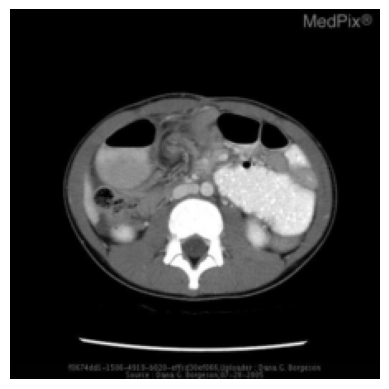

Question: Can you evaluate a mediastinum in the shown image?
Generated Answer: yes
Ground Truth Answer: No
--------------------------------------------------


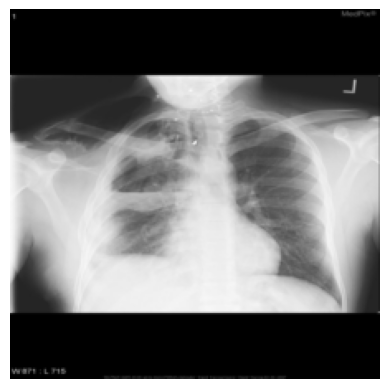

Question: What are the two major organs present in this image?
Generated Answer: 
Ground Truth Answer: Heart 	lungs
--------------------------------------------------


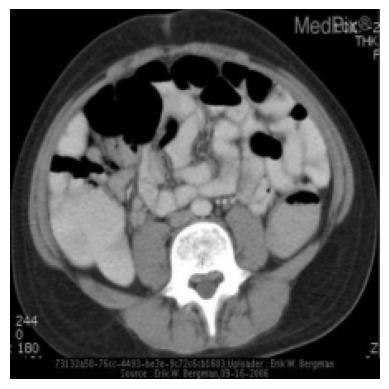

Question: What is the hypo-dense area seen in the vertebrae?
Generated Answer: the
Ground Truth Answer: Nucleus Pulposus
--------------------------------------------------


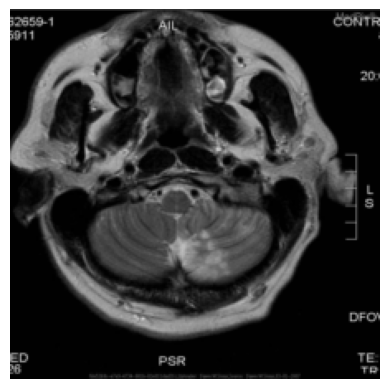

Question: is there any shift of midline structures visible in this section?
Generated Answer: yes
Ground Truth Answer: no
--------------------------------------------------


In [49]:
batch = next(iter(train_dataloader))
display_vqa_results(model, batch, tokenizer, device='cuda')

In [12]:
import cv2

In [24]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks and store handles to remove them later
        self.forward_hook_handle = self.target_layer.register_forward_hook(self._save_activations)
        self.backward_hook_handle = self.target_layer.register_backward_hook(self._save_gradients)

    def _save_activations(self, module, input, output):
        self.activations = output[0].detach() if isinstance(output, tuple) else output.detach()

    def _save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach() if isinstance(grad_output, tuple) else grad_output.detach()

    def __call__(self, inputs, attention_mask, images, decoder_input_ids, target_ids):
        # Forward pass to get model outputs
        outputs = self.model(inputs, attention_mask, images, decoder_input_ids, target_ids)
        logits = outputs['logits']

        # Get the predicted class for each sample in the batch
        scores = []
        for i in range(logits.size(0)):  # Iterate over batch size
            class_id = logits[i, -1].argmax().item()
            scores.append(logits[i, -1, class_id])

        # Stack scores to form a tensor and backward to get gradients
        score = torch.stack(scores)
        score.backward(torch.ones_like(score), retain_graph=True)
        
        # Compute weights by averaging gradients over the sequence length
        weights = self.gradients.mean(dim=1, keepdim=True)
        grad_cam = F.relu((weights * self.activations).sum(dim=-1))  # Sum over hidden size

        # Scale Grad-CAM values for visibility (optional)
        grad_cam = grad_cam * 10  # Amplify if needed
        grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)  # Normalize

        # Ensure grad_cam has the correct dimensions for interpolation
        grad_cam = grad_cam.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        grad_cam = F.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False).squeeze()

        return grad_cam

    def remove_hooks(self):
        """Remove hooks to prevent them from persisting during training."""
        self.forward_hook_handle.remove()
        self.backward_hook_handle.remove()

In [25]:
target_layer = model.multimodal_encoder[-1].attention  # Adjust layer as needed
grad_cam = GradCAM(model, target_layer)

In [26]:
# Get a single sample from the test dataloader
sample = next(iter(test_dataloader))
images, questions, answers = sample
image = images[1].unsqueeze(0).to(device)  # Single image with batch dimension
question = [questions[0]]
answer = answers[0]

# Tokenize question
encoding = tokenizer(question, padding='max_length', truncation=True, max_length=12, return_tensors='pt')
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
decoder_input_ids = torch.full((input_ids.size(0), input_ids.size(1)), tokenizer.cls_token_id, device=device)

# Generate Grad-CAM output
grad_cam_output = grad_cam(input_ids, attention_mask, image, decoder_input_ids, None)

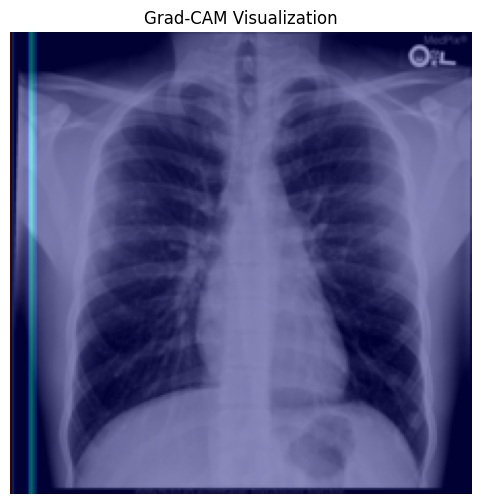

In [27]:
# Visualization function
def visualize_grad_cam(image, grad_cam_output):
    # Convert Grad-CAM output to a color map
    grad_cam_output = grad_cam_output.cpu().numpy()
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_output), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Convert the original image to [0, 255] range and overlay
    original_image_np = (image.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    overlayed_image = cv2.addWeighted(original_image_np, 0.6, heatmap, 0.4, 0)

    # Plot the result
    plt.figure(figsize=(6, 6))
    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.title("Grad-CAM Visualization")
    plt.show()

# Visualize
visualize_grad_cam(image, grad_cam_output)

In [17]:
grad_cam.remove_hooks()
del grad_cam_output  # Delete the Grad-CAM output to free memory
torch.cuda.empty_cache()